<a href="https://colab.research.google.com/github/gulabpatel/Computer_Vision/blob/main/Part%201%3A%20HandWritten_character_recognition_using_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To install a package, if it is not present in goole colaboratory, use the following code

**!pip install packageName**

In [1]:
!pip install wget

import required packages

In [2]:
import os
import numpy as np
import cv2 
import wget 

create a directory and change the current directory

In [3]:
!pwd

/content


In [4]:
rootDir='./Data'
os.makedirs(rootDir, exist_ok=True)    
        
os.chdir(rootDir)

In [5]:
!pwd

/content/Data


Download dataset in the current directory. Information regarding these dataset can be found @ http://yann.lecun.com/exdb/mnist/

In [6]:
url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
wget.download(url)

url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
wget.download(url)

't10k-labels-idx1-ubyte (1).gz'

Extract the training data and store it in Train folder

In [7]:
import gzip

fx = gzip.open('train-images-idx3-ubyte.gz','r')
fx.read(8)

b'\x00\x00\x08\x03\x00\x00\xea`'

In [8]:
image_size = 28
import gzip

fx = gzip.open('train-images-idx3-ubyte.gz','r')
fx.read(16)
fy = gzip.open('train-labels-idx1-ubyte.gz','r')
fy.read(8)
count=0
while 1:
    labBuff=fy.read(1)
    if not labBuff:
        break
    label = np.frombuffer(labBuff, dtype=np.uint8)[0]
    buf = fx.read(image_size * image_size )
    data = np.frombuffer(buf, dtype=np.uint8)
    image = data.reshape(image_size, image_size)
    parentDir='Train'+os.sep+str(label)
    os.makedirs(parentDir, exist_ok=True)    
    cv2.imwrite(parentDir+os.sep+str(count)+'.png',image)  
    count += 1

Extract the testing data and store it in Test folder

In [9]:
fx = gzip.open('t10k-images-idx3-ubyte.gz','r')
fx.read(16)
fy = gzip.open('t10k-labels-idx1-ubyte.gz','r')
fy.read(8)
count=0
while 1:
    labBuff=fy.read(1)
    #print(labBuff)
    if not labBuff:
        break
    label = np.frombuffer(labBuff, dtype=np.uint8)[0]
    buf = fx.read(image_size * image_size )
    #print(buf)
    data = np.frombuffer(buf, dtype=np.uint8)
    image = data.reshape(image_size, image_size)
    parentDir='Test'+os.sep+str(label)
    os.makedirs(parentDir, exist_ok=True)    
    cv2.imwrite(parentDir+os.sep+str(count)+'.png',image)  
    count += 1

Let create Training and Testing Dataset

In [10]:
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
import cv2 

print(os.getcwd())
rootDir='/'
os.chdir(rootDir)

/content/Data


In [11]:
!pwd

/


In [12]:
rootDir='./content/Data/Train'
trainList=[]
for path, subdirs, files in os.walk(rootDir):
  for name in files:
    if not name.endswith('.png'):
        continue  
    
    imPath=os.path.join(path, name); 
    # print(imPath)
    parts=imPath.split(os.sep);   
    trainList.append([imPath, int(parts[-2])])
        
        
rootDir='./content/Data/Test'
testList=[]
for path, subdirs, files in os.walk(rootDir):
    for name in files:
        if not name.endswith('.png'):
            continue  
        
        imPath=os.path.join(path, name); 
        # print(imPath)
        parts=imPath.split(os.sep); 
        testList.append([imPath, int(parts[-2])])


#Create MNIST Dataset

In [13]:
class create_mnist_dataset(object):
    def __init__(self,batch_size):
        self.batch_size=batch_size
    def gen(self,dataList, phase='Train'):
        inps=[]
        labels=[]
        try:
          while 1:
              shuffle(dataList)
              for imPath, label in dataList:
                  # print(imPath)
                  tmp=np.zeros((1,1,10),dtype='uint8')
                  tmp[0,0,int(label)]=1
                  labels.append(tmp.copy())
                  image=cv2.imread(imPath,0) ### we want to read image as gray
                  image.shape
                  inps.append(np.expand_dims(image,axis=-1))
                  if len(labels)==self.batch_size:            
                      yield np.asarray(inps,dtype='float32'), np.asarray(labels,dtype='float32')
                      inps=[]
                      labels=[]
              if phase=='Test':
                  break
        except GeneratorExit:
          print("Generated Finished")

batch_size=256
# print(len(trainList))
dataset=create_mnist_dataset(batch_size)
traindata=dataset.gen(trainList)

#Plot data

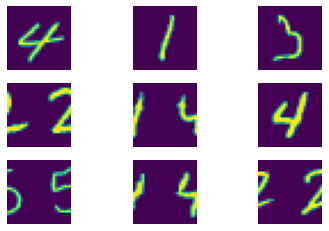

In [14]:
#%matplotlib inline

testdata=dataset.gen(testList,phase='Test')
vimages, vclasses = next( testdata)

# Fill out the subplots with the random images that you defined 
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(vimages[i].reshape(28,28))
    plt.subplots_adjust(wspace=0.5)
plt.show()

#Parameter Initialization


In [15]:
# Parameters
learning_rate = 0.01
training_iteration = 5000
display_step = 10


# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

#Weight and Bias Initialization

In [16]:
# Store layers weight & bias

initializer=tf.keras.initializers.HeNormal()  
# initializer=tf.keras.initializers.HeUniform()
# initializer = tf.initializers.orthogonal(gain=1.0) 
# initializer = tf.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')  
# initializer = tf.initializers.glorot_uniform()  
# initializer = tf.initializers.glorot_normal()  
# initializer = tf.initializers.RandomUniform(minval=-1.0, maxval=1.0)  
# initializer = tf.initializers.RandomNormal(mean=0, stddev=1.0)  

# Store layers weight & bias
weights = {
    'h1': tf.Variable(initializer([n_input, n_hidden_1]),trainable=True),
    'h2': tf.Variable(initializer([n_hidden_1, n_hidden_2]),trainable=True),
    'out': tf.Variable(initializer([n_hidden_2, n_classes]),trainable=True)
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1]),trainable=True),
    'b2': tf.Variable(tf.zeros([n_hidden_2]),trainable=True),
    'out': tf.Variable(tf.zeros([n_classes]),trainable=True)
}

varList=[]
for key in weights:
  varList.append(weights[key])
for key in biases:
  varList.append(biases[key])

#Model Building

In [17]:
# Create model
def multilayerNN(x):
    x=tf.reshape(x,[-1,1,1,n_input])
    # print(tf.reduce_mean(x))
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1=tf.nn.leaky_relu(    layer_1,    alpha=0.2)
    # print(weights['h1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2=tf.nn.leaky_relu(    layer_2,    alpha=0.2)
    # print(layer_2)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # y=tf.nn.sigmoid(out_layer)
    # y=tf.clip_by_value(tf.nn.softmax(out_layer),0.01,0.99)
    y=tf.nn.softmax(out_layer)
    return y


optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=10.0**-7)
# optimizer = tf.keras.optimizers.SGD( learning_rate=learning_rate, momentum=0.0)

#Training

In [ ]:
iteration=0
while iteration<training_iteration:
  iteration = iteration + 1 
  images, classes = next(traindata)
  # print(classes)
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.convert_to_tensor(classes)
  with tf.GradientTape(watch_accessed_variables=True) as tape:
    tape.watch(varList)
    y = multilayerNN(images)
    # print(y)
    loss = tf.reduce_mean(-classes*tf.math.log(y))

  gradients = tape.gradient(loss, varList)
  optimizer.apply_gradients(zip(gradients, varList))

  
  # Display loss per epoch step
  if iteration % display_step == 0:
      print("iteration:", '%04d' % (iteration), "cost={:.9f}".format(loss))

iteration: 0010 cost=0.308579445
iteration: 0020 cost=0.291639149
iteration: 0030 cost=0.271408468
iteration: 0040 cost=0.270296723
iteration: 0050 cost=0.252011687
iteration: 0060 cost=0.247878119
iteration: 0070 cost=0.233165935
iteration: 0080 cost=0.226987362
iteration: 0090 cost=0.226928234
iteration: 0100 cost=0.227312952
iteration: 0110 cost=0.219239518
iteration: 0120 cost=0.216901109
iteration: 0130 cost=0.220901370
iteration: 0140 cost=0.210094139
iteration: 0150 cost=0.198058769
iteration: 0160 cost=0.206149548
iteration: 0170 cost=0.199050710
iteration: 0180 cost=0.196185350
iteration: 0190 cost=0.194025636
iteration: 0200 cost=0.188180640
iteration: 0210 cost=0.185886979
iteration: 0220 cost=0.184334010
iteration: 0230 cost=0.178885847
iteration: 0240 cost=0.172375113
iteration: 0250 cost=0.168107316
iteration: 0260 cost=0.167498857
iteration: 0270 cost=0.165391773
iteration: 0280 cost=0.162013143
iteration: 0290 cost=0.171202257
iteration: 0300 cost=0.164727554
iteration:

# Testing

In [20]:
print(len(testList))
testdata=dataset.gen(testList,phase='Test')

totalN=0
totalP=0
while True:
  try:
    images, classes = next(testdata)
  except:
    break
  # print(classes)
  images=tf.convert_to_tensor(images)
  images=(images-127.5)/127.5
  classes=tf.convert_to_tensor(classes)
  y = multilayerNN(images)
  yclass=tf.argmax(y,axis=-1)
  classes=tf.argmax(classes,axis=-1)

  p=tf.reduce_sum(tf.cast( tf.equal(yclass,classes), dtype='float32'))
  totalP = totalP + p
  totalN = totalN + batch_size

  if iteration % display_step == 0:
      print("totalN:", '%04d' % (totalN), "totalP:", '%04d' % (totalP), "Accuracy={:.9f}".format(totalP*100/totalN))

18968
totalN: 0256 totalP: 0132 Accuracy=51.562500000
totalN: 0512 totalP: 0265 Accuracy=51.757812500
totalN: 0768 totalP: 0406 Accuracy=52.864582062
totalN: 1024 totalP: 0537 Accuracy=52.441406250
totalN: 1280 totalP: 0674 Accuracy=52.656250000
totalN: 1536 totalP: 0809 Accuracy=52.669269562
totalN: 1792 totalP: 0930 Accuracy=51.897319794
totalN: 2048 totalP: 1065 Accuracy=52.001953125
totalN: 2304 totalP: 1206 Accuracy=52.343750000
totalN: 2560 totalP: 1329 Accuracy=51.914062500
totalN: 2816 totalP: 1466 Accuracy=52.059658051
totalN: 3072 totalP: 1610 Accuracy=52.408855438
totalN: 3328 totalP: 1730 Accuracy=51.983173370
totalN: 3584 totalP: 1862 Accuracy=51.953125000
totalN: 3840 totalP: 1991 Accuracy=51.848957062
totalN: 4096 totalP: 2109 Accuracy=51.489257812
totalN: 4352 totalP: 2239 Accuracy=51.447608948
totalN: 4608 totalP: 2378 Accuracy=51.605903625
totalN: 4864 totalP: 2514 Accuracy=51.685855865
totalN: 5120 totalP: 2636 Accuracy=51.484375000
totalN: 5376 totalP: 2749 Accuracy

In the next notebook, we will use CNN to improve the accuracy.

--------------------------------